In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
matplotlib.rcParams['text.usetex'] = True
import time

plt.style.use('../plotstyle.txt')
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator

## Like charge attraction

Let us set up our system. We observe two 1-dimensional arrays of charges, which are to represent our parallel straight DNA strands, and divalent ions in solution which can be bound to the DNA negative charge sites or unbounded. There are $N$ charges on our DNA, each of them are either $-e$ (phosphate group) or $(\alpha-1)e$ (phosphate group with ion  of charge $\alpha e$ bound). The distance between the successive charges is $b$. On the first strand, there are $n_1$ ions bound in some arrangement, and $n_2$ for the second strand. The arrangement is dictated by two 1-D arrays (one for each strand) with entry 1 if there is an ion bound to the phosphate site or 0 if there is not. A simpler way to represent this i to stack them into a $2\times N$ matrix $\sigma_{ij}$. The distance between the two strands is $d$.

Let $i,i'$ be a discrete variables from 1 to $N$ and let $j,j'$ be that for just the pair $\{1,2\}$. The Hamiltonian of this system is then represented by:

\begin{equation}
    E = \frac{e^2}{4\pi b\epsilon_0\epsilon_r}\sum^{N}_{i,i'=1}\sum^{2}_{j,j'=1}\frac{\left(1-\alpha\sigma_{ij}\right)\left(1-\alpha\sigma_{i'j'}\right)}{\sqrt{(i-i')^2 + \left(1 - \delta_{jj'}\right)x^2}},
\end{equation}

where $x = \frac{d}{b}$, and the sum omits $i = i', j = j'$ instances. We can define
\begin{equation}
    \xi = \frac{e^2}{4\pi\epsilon_0\epsilon_rbk_BT},
\end{equation}

and therefore:
\begin{equation}
    E = \xi k_BT\sum^{N}_{i,i'=1}\sum^{2}_{j,j'=1}\frac{\left(1-\alpha\sigma_{ij}\right)\left(1-\alpha\sigma_{i'j'}\right)}{\sqrt{(i-i')^2 + \left(1 - \delta_{jj'}\right)x^2}},
\end{equation}

Some constraints of the model to keep in mind:

- The two strands are straight and parallel to each other
- The ions (represented as point particles) change each of the strands just enough to renormalise the local charge (change the charge of the negative binding site)
- The strands are exactly of the same length
- The system is at a constant temperature of 300 K

We are implementing a Monte-Carlo Metropolis algorithm to find the distribution of energies within the system and which conformations are most desireable (the one corresponding to the lowest energy). If we wanted to find the partition function we would have to find the energies of every single possible state of our system (say there are $M$ of them), and compute the partition function like:
\begin{equation}
    Q = \sum_{i = 1}^{M}\mathrm{e}^{-E_{i}/k_BT}
\end{equation}

To do this, we will compute only a sample of the allowed energies and make an algorithm which is biased towards the favoured energies. The way we do that is we set up a random system of two strands with N available sites each and $n_1$, $n_2$ ions on each of those sites distributed randomly. We then choose a random ion on both strands, and put it in an empty site on the same strand. This way we randomly perturb the system and observe the energy change. If the energy is lower, we 'accept' this system and go back to randomly moving ions to again perturb and seek a lower energy state. If the energy of the new system is larger than that of the old one, we accept it with a Boltzmann probability, and it is otherwise rejected. Accepting with a Boltzmann probability means generating a random number $\eta$ between 0 and 1 and checking to see if
\begin{equation}
    \eta > \mathrm{e}^{\left[E_{\text{old}} - E_{\text{new}}\right]/k_BT},
\end{equation}

where $E_{\text{old}}$ is the energy of the old state and $E_{\text{new}}$ is the energy of the new state. If above is satisfied, then we accept the new energy even if it is higher than the previous one. 'Rejection' means that the ions are swapped back and the system seeks a lower energy from the previous step. In the middle of this, we have to keep in mind the conformation of the system so that we do not repeat it. We do this by keeping an index log file of places where the ions are, and we only run the algorithm if the new ion indices do not appear in the index log file. That way we will not explore the same energy state twice, and mistakenly accept it twice (the algorithm would be biased).

Then, when we have the sample which is already weighted to the desired distribution by the virtue of the MC algorithm and we can use the formula above to find the partition function based on our sample. We can do this for many distances between the two strands and we can then find the force with the following formula:
\begin{equation}
    F = \frac{k_BT}{b}\frac{\partial }{\partial x}\ln(Q),
\end{equation}

where it can be noticed that the derivative is a dimensionless quantity. Just for visual clarity, we can non-dimensionalise and rescale this force with the natural choice of units:
\begin{equation}
    \tilde{F} = \frac{4\pi\epsilon_0\epsilon_rb^2}{e^2}\frac{k_BT}{b}\frac{\partial }{\partial x}\ln(Q) = \tilde{F}(x) = \frac{1}{\xi}\frac{\partial }{\partial x}\ln\left[\sum_{i = 1}^{M}\mathrm{e}^{-E_{i}(x)/k_BT}\right],
\end{equation}

or in a more accurate form:
\begin{equation}
    \boxed{\tilde{F}(x) = \frac{1}{\xi}\frac{\partial }{\partial x}\ln\left[\sum_{\text{all }\sigma_{ij}}\mathrm{e}^{-\xi \sum^{N}_{i,i'=1}\sum^{2}_{j,j'=1}\frac{\left(1-\alpha\sigma_{ij}\right)\left(1-\alpha\sigma_{i'j'}\right)}{\sqrt{(i-i')^2 + \left(1 - \delta_{jj'}\right)x^2}}}\right]}.
\end{equation}


In [4]:
# Global constants
e = 1.6*10**-19 #C
epsilon_0 = 8.85*10**-12 #Fm^-1
epsilon_r = 77.21
k_B = 1.380649*10**-23 #Jmol^-1
T = 300 #K
b = 6.76e-10 #m
a = 7.35e-10/b
K = e**2/(4*np.pi*epsilon_0*epsilon_r*k_B*T*b)

In [3]:
#This function makes a random discrete system particles with negative charge (represented with) -1 and ion-bounded
#sites which are +1. It is just a binary array and is the simplest possible description of the system
def make_random_system(N, n1, n2, n3, n4):
    narray1 = np.random.permutation(np.concatenate((np.zeros(N-n1), np.ones(n1)*2)))
    narray2 = np.random.permutation(np.concatenate((-np.ones(N-n2), np.ones(n2))))
    narray3 = np.random.permutation(np.concatenate((-np.ones(N-n3), np.ones(n3))))
    narray4 = np.random.permutation(np.concatenate((np.zeros(N-n4), np.ones(n4)*2)))
    narray = np.concatenate((narray1, narray2, narray3, narray4))
    return narray1, narray2, narray3, narray4, narray

In [4]:
#Defining a function whose input is the array describing the charges, the distance between the two strands, and 
#the distance between successive charges on the DNA, and outputs the potential energy in units of k_B*T
# s is the horizontal shift of the second strand: it can be between -1/2 and 1/2
def potential_energy(array, x, s):
    pot_en = 0
    n = int(len(array))
    for i in range(n):
            for j in range(i+1,n):
                if (i < n/4):
                    if (j < n/4):
                        pot_en += array[i]*array[j]/(j-i)
                    if (j >= n/4 and j < n/2):
                        pot_en += array[i]*array[j]/np.sqrt((j - i - n/4 + 1/2)**2 + a**2)
                    if (j >= n/2 and j < 3*n/4):
                        pot_en += array[i]*array[j]/np.sqrt((j - i - n/2 + 1/2 + s)**2 + (a + x)**2)
                    if (j >= 3*n/4):
                        pot_en += array[i]*array[j]/np.sqrt((j - i - 3*n/4 + s)**2 + (2*a + x)**2)
                if (i >= n/4 and i < n/2):
                    if (j < n/2):
                        pot_en += array[i]*array[j]/((j-i))
                    if (j >= n/2 and j < 3*n/4):
                        pot_en += array[i]*array[j]/np.sqrt((j - i - n/4 + s)**2 + x**2)
                    if (j >= 3*n/4):
                        pot_en += array[i]*array[j]/np.sqrt((j - i - n/2 - 1/2 + s)**2 + (a + x)**2)
                if (i >= n/2 and i < 3*n/4):
                    if (j < 3*n/4):
                        pot_en += array[i]*array[j]/(j-i)
                    if (j >= 3*n/4):
                        pot_en += array[i]*array[j]/np.sqrt((j - i - n/4 - 1/2)**2 + a**2)
                if (i >= 3*n/4):
                    pot_en += array[i]*array[j]/((j-i))
    return pot_en*K

#### FOR CHECKING: BELOW IS THE FORMULA FOR TWO dsDNA WITH TWO BINDING SITES ON EACH STRAND (8 IN TOTAL)
def potential_check(x):
    return K*(-4 + 2/np.sqrt(a**2 + 1/4) - 2/np.sqrt(a**2 + 9/4) + 2/(2*a + x) + 2/np.sqrt((a + x)**2 + 1/4) - 2/np.sqrt((2*a + x)**2 + 1) - 2/np.sqrt((a + x)**2 + 9/4) - 2/np.sqrt(x**2 + 1) + 2/x)

In [5]:
#This function sweeps the two strands and swaps randomly an ion with an unoccupied site
def swap_ions(narray1, narray2, narray3, narray4):
    index1a = np.random.choice(np.where(narray1 == 0)[0])
    index1b = np.random.choice(np.where(narray1 == 2)[0])
    index2a = np.random.choice(np.where(narray2 == -1)[0])
    index2b = np.random.choice(np.where(narray2 == 1)[0])
    index3a = np.random.choice(np.where(narray3 == -1)[0])
    index3b = np.random.choice(np.where(narray3 == 1)[0])
    index4a = np.random.choice(np.where(narray4 == 0)[0])
    index4b = np.random.choice(np.where(narray4 == 2)[0])
    narray1[index1a], narray1[index1b] = narray1[index1b], narray1[index1a]
    narray2[index2a], narray2[index2b] = narray2[index2b], narray2[index2a]
    narray3[index3a], narray3[index3b] = narray3[index3b], narray3[index3a]
    narray4[index4a], narray4[index4b] = narray4[index4b], narray4[index4a]
    narray = np.concatenate((narray1, narray2, narray3, narray4))
    indices = [index1a, index1b, index2a, index2b, index3a, index3b, index4a, index4b]
    return narray1, narray2, narray3, narray4, narray, indices

In [6]:
#This function undoes the action of the previous function (it is called if the new state is rejected)
def swap_ions_back(narray1, narray2, narray3, narray4, ind):
    index1a = ind[0]
    index1b = ind[1]
    index2a = ind[2]
    index2b = ind[3]
    index3a = ind[4]
    index3b = ind[5]
    index4a = ind[6]
    index4b = ind[7]
    narray1[index1a], narray1[index1b] = narray1[index1b], narray1[index1a]
    narray2[index2a], narray2[index2b] = narray2[index2b], narray2[index2a]
    narray3[index3a], narray3[index3b] = narray3[index3b], narray3[index3a]
    narray4[index4a], narray4[index4b] = narray4[index4b], narray4[index4a]
    return narray1, narray2, narray3, narray4

In [27]:
#Main Monte Carlo algorithm. Slight energy perturbations lead to acceptance of lower energy or, acceptance of higher
#energy according to a Boltzman distribution. It outputs the partition function value at a specific distance
def monte_carlo(M, N, n1, n2, n3, n4, x, s, check_time, plotting):
    t = 0
    rejected = 0
    accepted = 1
    illegal_swap = 0
    energies = []
    strand1, strand2, strand3, strand4, system = make_random_system(N, n1, n2, n3, n4)
    en = potential_energy(system, x, s)
    energies.append(en)
    check_array = np.concatenate((np.where(system == 0)[0], np.where(system == 1)[0]))
    t0 = time.process_time()
    while (t<M-1):
        t+=1
        strand1, strand2, strand3, strand4, system, indices = swap_ions(strand1, strand2, strand3, strand4)
        test = np.concatenate((np.where(system == 0)[0], np.where(system == 1)[0]))
        if not any(np.array_equal(l, test) for l in check_array):
            check_array = np.vstack((check_array, test))
            entest = potential_energy(system, x, s)
            if (entest>en):
                eta = np.random.rand(1)[0]
                if np.exp(en - entest) > eta:
                    en = entest
                    energies.append(en)
                    accepted +=1
                    lastsystem = system
                else:
                    swap_ions_back(strand1, strand2, strand3, strand4, indices)
                    rejected += 1
            else:
                en = entest
                energies.append(en)
                accepted +=1
                lastsystem = system
        else:
            illegal_swap +=1
    t1 = time.process_time() - t0
    if check_time:
        print('It took the MC method ' + str(t1) + ' seconds to complete ' + str(M) + ' loops, for an average of ' + str(t1/M) + ' seconds per loop.')
    if plotting:
        fig, ax = plt.subplots(figsize=(len(system)/(2*a + x), 4))
        colorsphosphate = ['yellow', 'grey', 'violet', 'green']
        colorsmajor = ['lightblue', 'lightgreen', 'whatever', 'violet']
        for i in range(int(len(system)/4)):
            ax.add_patch(plt.Circle((i - N/2, x/2 + a), 0.3, color = colorsmajor[int(lastsystem[i])+1]))
            ax.text(i - N/2 - 0.05, x/2 + a - 0.04, int(lastsystem[i]))
            ax.add_patch(plt.Circle((i - N/2 + 1/2, x/2), 0.3, color = colorsphosphate[int(lastsystem[i + int(N)])+1]))
            ax.text(i - N/2 + 1/2 - 0.05, x/2 - 0.04, int(lastsystem[i + int(N)]))
            ax.add_patch(plt.Circle((i - N/2 + 1/2 + s, - x/2), 0.3, color = colorsphosphate[int(lastsystem[i + int(2*N)])+1]))
            ax.text(i - N/2 + 1/2 - 0.05 + s, - x/2 - 0.04, int(lastsystem[i + int(2*N)]))
            ax.add_patch(plt.Circle((i - N/2 + s, - a - x/2), 0.3, color = colorsmajor[int(lastsystem[i + int(3*N)])+1]))
            ax.text(i - N/2 - 0.05 + s, - a - x/2 - 0.04, int(lastsystem[i + int(3*N)]))
        ax.set_xlabel(r'$x ~ / ~ b$')
        ax.set_ylabel(r'$y ~ / ~ b$')
        ax.axis('equal')
        ax.set_ylim(- a - x/2 - 1, a + x/2 + 1)
    return energies, np.log(np.sum(np.exp(-np.array(energies)))), [accepted, rejected, illegal_swap], lastsystem

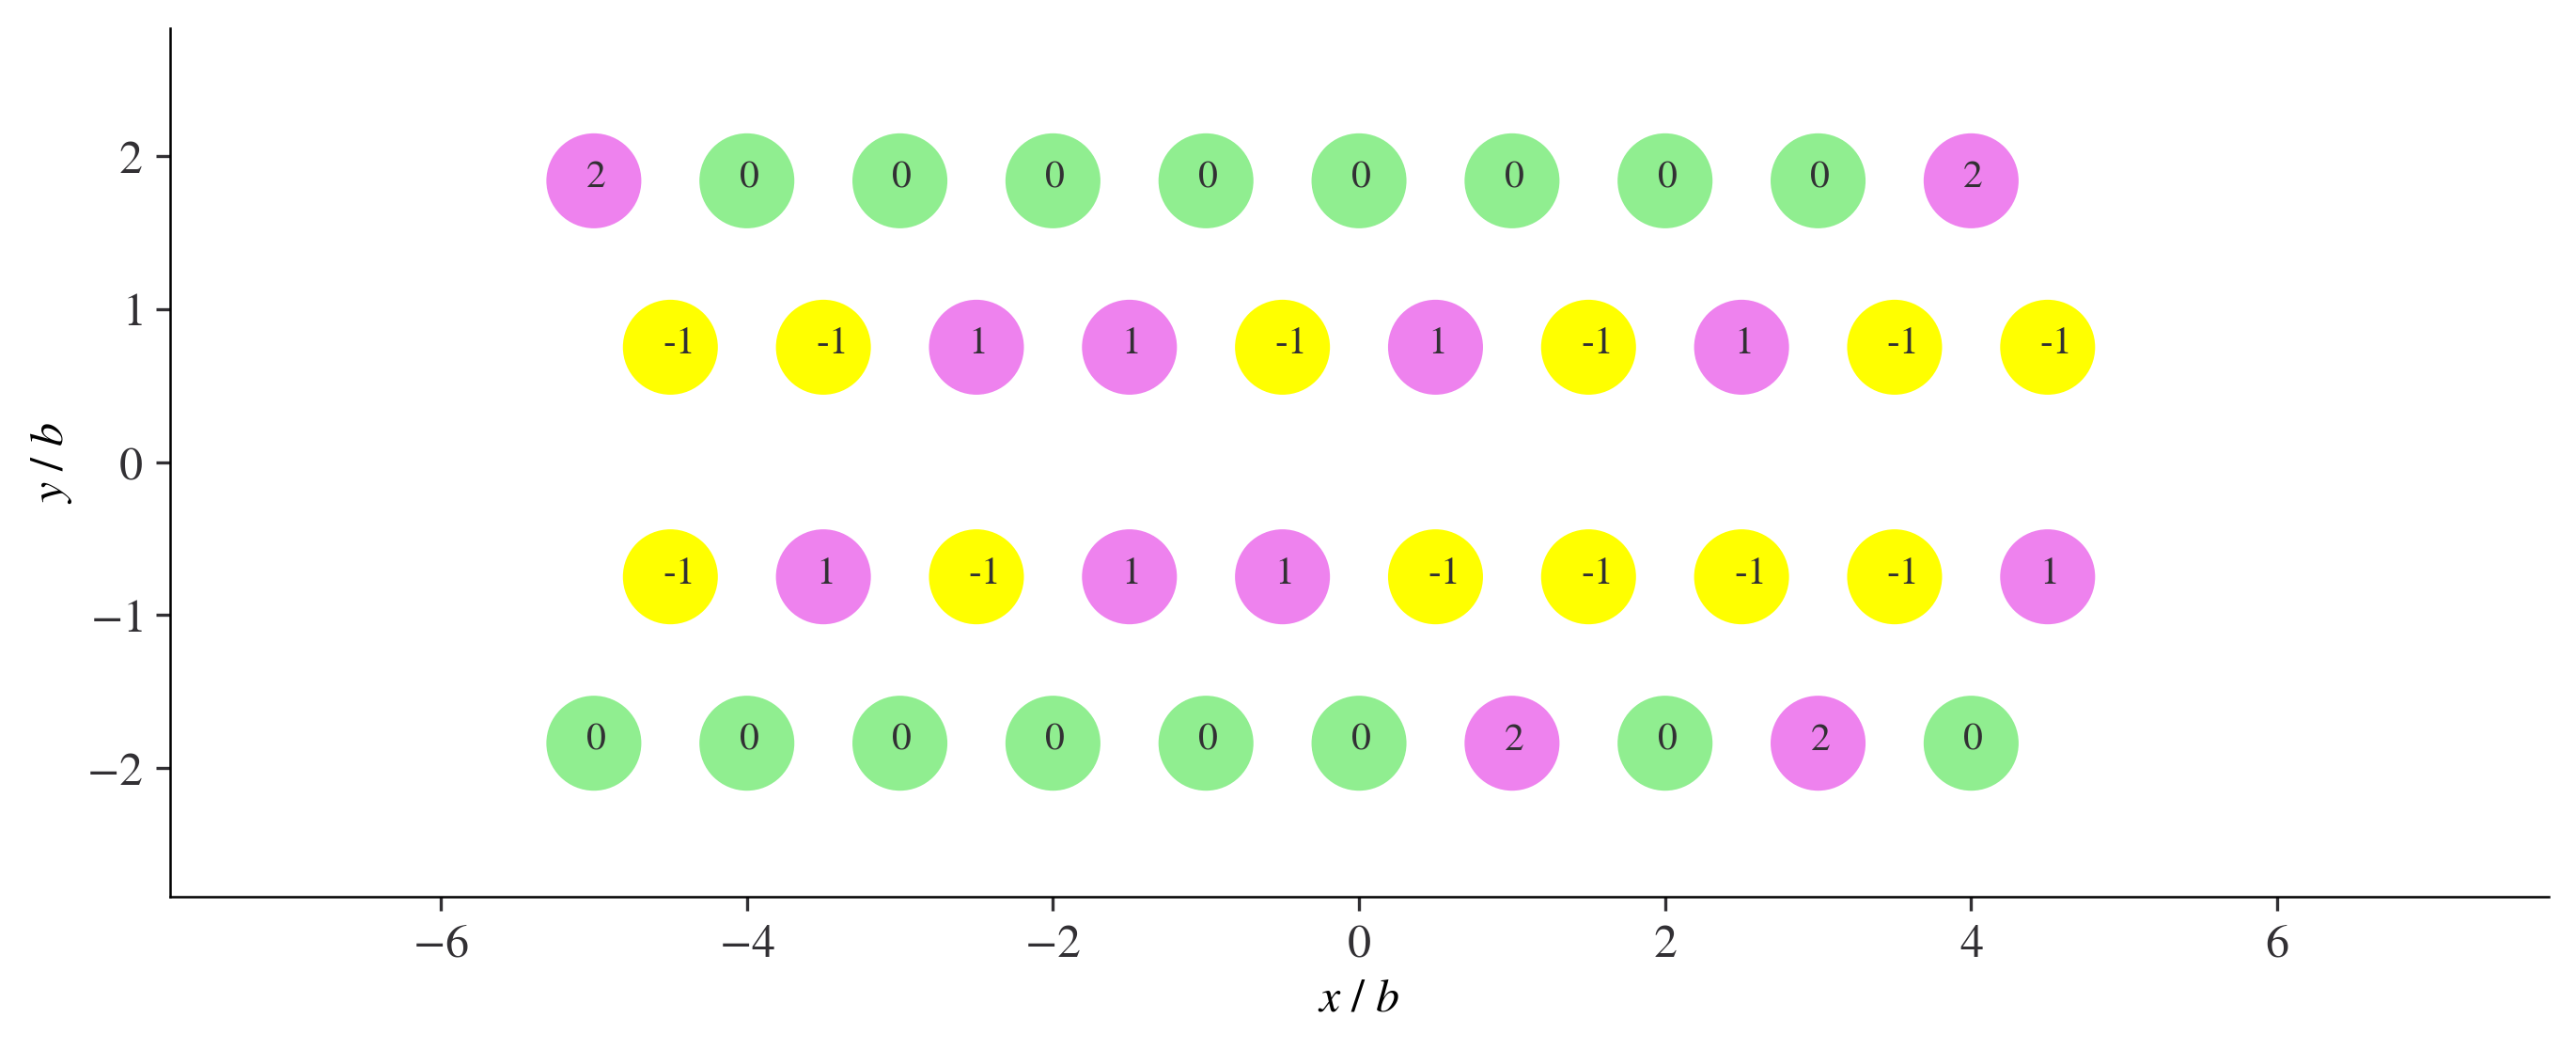

In [29]:
energies, partition, log, system = monte_carlo(200, 10, 2, 4, 4, 2, 1.5, 0, check_time = False, plotting = True)
plt.savefig('../complex_demo.png')

## SOME TESTS

Below is the demonstration of the code for two DNA of 40 binding sites each. The fractional occupancy varies from 11% to 89% and I plot the force and partition function as functions of distance for each case.

In [330]:
N = 10 #distance range
M = 9 #number of conformations + 1

In [333]:
j=1
partitions = np.zeros((M-1, N))
distance = np.zeros((M-1, N))
while j<M:
    i=0
    t0 = time.process_time()
    while i<N:
        partitions[j-1, i] = monte_carlo(1000, 20, j, 9-j, 9-j, j, (i + 1)*0.2, 0, check_time = False, plotting = False)[1]
        distance[j-1, i] = (i + 1)*0.2
        i+=1
    t1 = time.process_time() - t0
    print('Finished with the', str(j) + 'th run in', t1, 'seconds.')
    j+=1

np.save("data/partitions_N=20_M=500_fractions.npy", partitions)
np.save("data/distances_N=20_M=500_fractions.npy", distance)

Finished with the 1th run in 97.98321846700003 seconds.
Finished with the 2th run in 98.00353579700004 seconds.
Finished with the 3th run in 98.41411257900006 seconds.
Finished with the 4th run in 98.28001527100002 seconds.
Finished with the 5th run in 98.03388606700003 seconds.
Finished with the 6th run in 97.68408974600004 seconds.
Finished with the 7th run in 97.29992371200001 seconds.
Finished with the 8th run in 97.48010127099997 seconds.


I save these above so I can load them whenever I want (e.g. for plotting).

Below is a test to see how quickly the above Monte Carlo simulation converges in terms of the partition function (in other words, to justify why M = 500).

In [ ]:
N = 20 #distance range
    
i=1
partitionstest = np.zeros(N)
t = np.zeros(N)
iterations = np.zeros(N)
while i<21:
    t0 = time.process_time()
    partitionstest[i - 1] = monte_carlo(i*100, 20, 3, 6, 6, 3, 1, 0, check_time = False, plotting = False)[1]
    t1 = time.process_time() - t0
    t[i - 1] = t1
    iterations[i - 1] = i*100
    print('Finished with the', str(i) + 'th run in', t1, 'seconds.')
    i+=1

np.save("data/t_testing_convergence.npy", t)
np.save("data/partitions_testing_convergence.npy", partitionstest)
np.save("data/iterations_testing_convergence.npy", iterations)